In [2]:
# Importando as bibliotecas
from CoolProp.CoolProp import PropsSI, PhaseSI
import pprint
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Variaveis de entrada
input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7
}

input_ranges = {
    # 'superheating_range': range(5,11),
    # 'subcooling_range': range(5,11),
    # 'refrigerants': ['R134a', 'R22', 'R290', 'R600a', 'R1234yf', 'NH3']
    'superheating_range': range(5,6),
    'subcooling_range': range(5,11),
    'refrigerants': ['R134a', 'R22']
}

input_values['cop_carnot'] = input_values['t_internal_env'] / (input_values['t_external_env'] - input_values['t_internal_env'])

In [4]:
# Calcula qualquer ponto informando dicionario com duas variaveis
def calculate_point(point):
    variables = ['T', 'H', 'S', 'Q', 'P']
    input_variables = list(point.keys())
    output_variables = [variable for variable in variables if variable not in input_variables]
    output_values = PropsSI(output_variables, 
                            input_variables[0], 
                            point[input_variables[0]], 
                            input_variables[1], 
                            point[input_variables[1]], 
                            input_values['refrigerant']
    )

    for index, variable in enumerate(output_variables):
        point[variable] = output_values[index]

    return point

In [5]:
# Calcula ciclo baseado nas variaveis de entrada
def calculate_cycle(cycle_inputs):
    point_1_saturado = {'Q': 1, 'T': cycle_inputs['t_internal_env'] - cycle_inputs['approach_evaporator']}
    calculate_point(point_1_saturado)

    point_1 = {'P': point_1_saturado['P'], 'T': point_1_saturado['T'] + cycle_inputs['superheating']}
    calculate_point(point_1)

    point_3_saturado = {'Q': 0, 'T': cycle_inputs['t_external_env'] + cycle_inputs['approach_condenser']}
    calculate_point(point_3_saturado)

    point_3 = {'P': point_3_saturado['P'], 'T': point_3_saturado['T'] - cycle_inputs['subcooling']}
    calculate_point(point_3)

    point_2_isen = {'S': point_1['S'], 'P': point_3['P']}
    calculate_point(point_2_isen)

    point_2 = point_2_isen
    point_2['H'] = point_1['H'] + (point_2_isen['H'] - point_1['H']) / cycle_inputs['isentropic_efficiency']

    point_4 = {'H': point_3['H']}

    m = cycle_inputs['q_evaporator'] / (point_1['H'] - point_4['H'])
    cop = (point_1['H'] - point_4['H']) / (point_2['H'] - point_1['H']) 

    return {
        'cycle_inputs': cycle_inputs,
        'point_1': point_1,
        'point_2': point_2,
        'point_3': point_3,
        'point_4': point_4,
        'm': m,
        'cop': cop,
        'exergy_efficiency': cop / cycle_inputs['cop_carnot']
    }

In [6]:
# Calcula melhor ciclo baseado nas variaveis de entrada e ranges de entrada
def calculate_best_cycle(cycle_inputs, cycle_ranges):
    results = pd.DataFrame(columns=['refrigerant', 'subcooling', 'superheating', 'cop'])
    result_by_cop = {}
    cops = []
    for subcooling in input_ranges['subcooling_range']:
        for refrigerant in input_ranges['refrigerants']:
            for superheating in input_ranges['superheating_range']:
                input_values['subcooling'] = subcooling
                input_values['refrigerant'] = refrigerant
                input_values['superheating'] = superheating
                cycle = calculate_cycle(input_values)   
                results = results.append({
                    'refrigerant': refrigerant,
                    'subcooling': subcooling,
                    'superheating': superheating,
                    'cop': cycle['cop']
                }, ignore_index=True)
                result_by_cop[cycle['cop']] = cycle
                cops.append(cycle['cop'])
    return results, result_by_cop[max(cops)]

In [9]:
def main():
    results, best_cycle = calculate_best_cycle(input_values, input_ranges)
    print('#'*30)
    print('Refrigerant: ', best_cycle['cycle_inputs']['refrigerant'])
    print('Subcooling: ', best_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', best_cycle['cycle_inputs']['superheating'])
    print('COP: ', best_cycle['cop'])
    print('Exergy efficiency: ', best_cycle['exergy_efficiency'])
    print('#'*30)
    
    results_R134a = results[results['refrigerant'] == 'R134a']
    ax = plt.subplot()
    for sh in results_R134a['superheating']:
        r = results_R134a[results_R134a['superheating'] == sh]
        ax.plot(r['subcooling'], r['cop'], 'o')
    plt.show()

##############################
Refrigerant:  R22
Subcooling:  10
Superheating:  5
COP:  4.752158396324679
Exergy efficiency:  0.27747447273748777
##############################


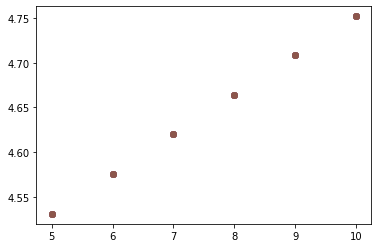

In [10]:
main()